# PCA-Based Outlier Detection

In [128]:
# Importing necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [129]:
from scipy.io import arff

In [130]:
# Reading the glass type data
data = pd.read_csv("data/glass.csv")
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [131]:
# Normalizing the data
X = data.copy()
X = (X-X.min(axis =0))/(X.max(axis = 0)-X.min(axis = 0))

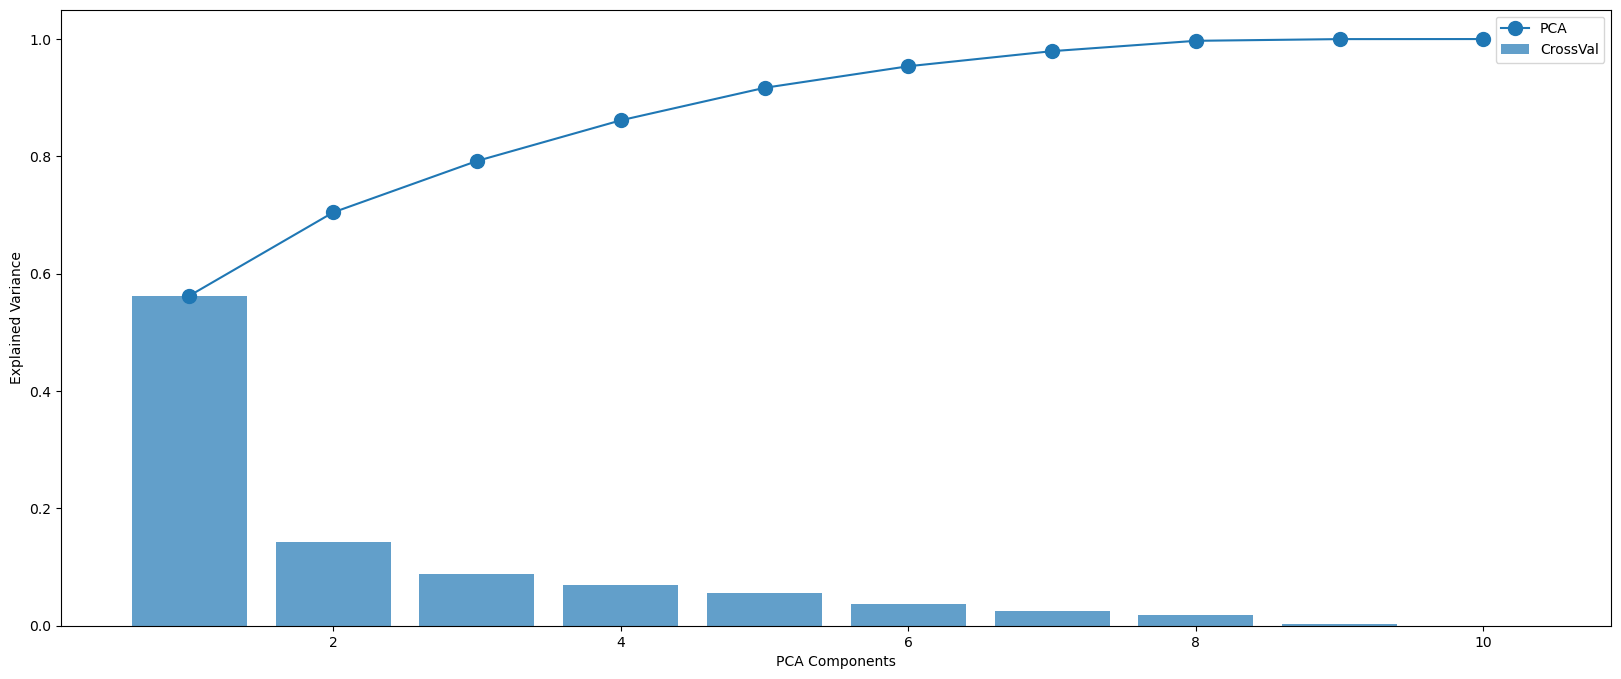

In [132]:
# Applying PCA
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)
# Variance explained by each component
variance_explained = pca.explained_variance_ratio_
# Plotting the variance explained by each component


# Plotting the variance of each component and their cumulative
cum_sum = np.cumsum(pca.explained_variance_ratio_)
comp= [n for n in range(1, len(cum_sum) + 1)]
plt.figure(figsize=(20, 8))
plt.plot(comp, cum_sum, marker='o',markersize=10)
plt.bar(comp, variance_explained, alpha=0.7, align='center')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance')
plt.legend(['PCA','CrossVal'])
plt.show()

## Reconstruction Error
<div>
<img src="RE.png" width="500"/>
</div>
$$
    \textrm{RE}(x)=\frac{\sum_{i=1}^{N}(x_i-\hat{x}_i)^2}{N}
$$
where
$$
  \hat{x}_i=\sum_{i=1}^{k}z_iv_i
$$

(Reference: https://www.analyticsvidhya.com/blog/2024/04/anomaly-detection-using-pca-unveiling-insights-in-data-anomalies/)

In [133]:
# Applying PCA with specific n components
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pca.transform(X)

# Calculating reconstruction error
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.mean(np.square(X - X_reconstructed), axis=1)

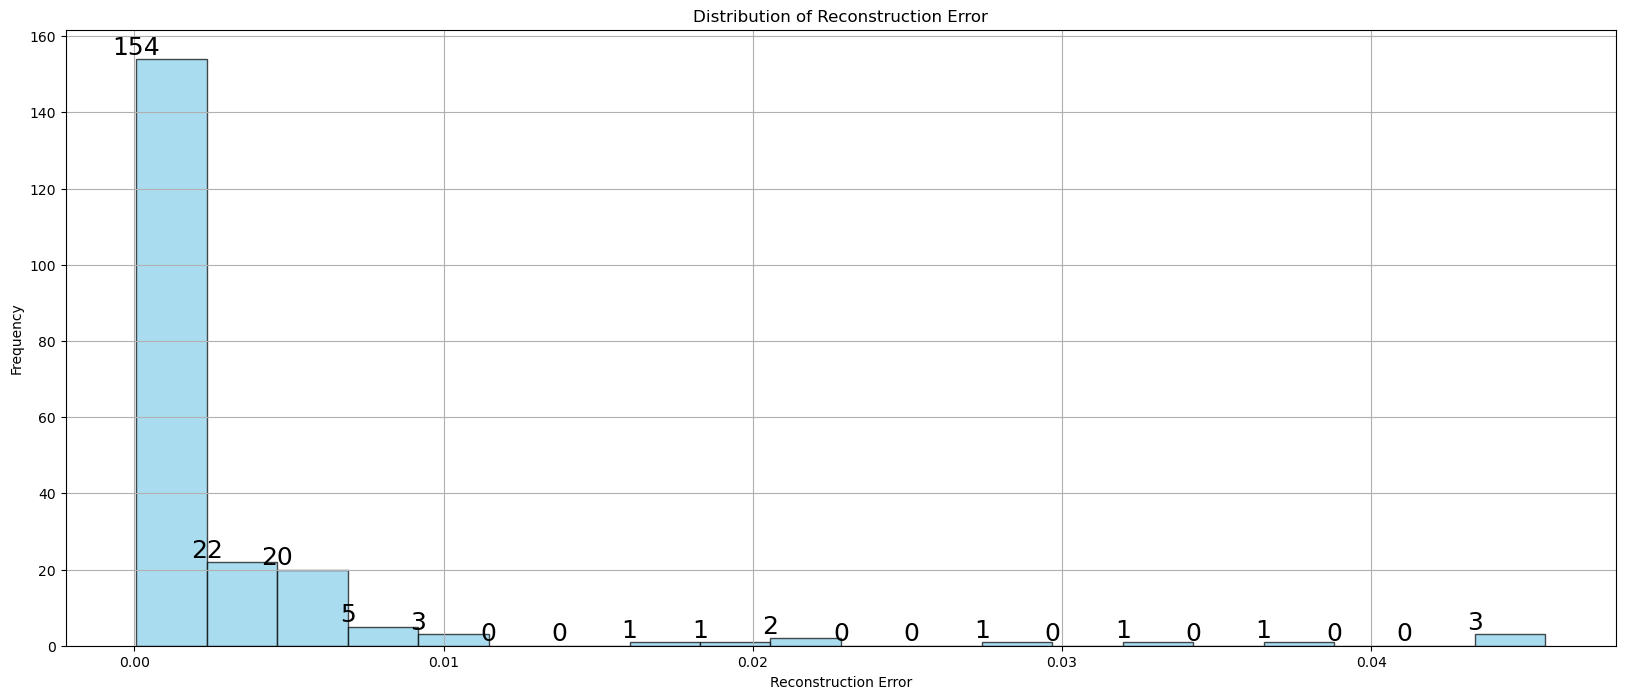

In [134]:
# Plotting distribution of the reconstruction error
plt.figure(figsize=(20, 8))
counts, bins, _ = plt.hist(reconstruction_error, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Error')
plt.grid(True)
# Annotate each bin with the count
for i in range(len(counts)):
    plt.text(bins[i], counts[i], str(int(counts[i])), ha='center', va='bottom', fontsize = 18)
plt.show()

In [135]:
# Outlier detection
threshold = np.percentile(reconstruction_error, 98)  # Adjust percentile as needed
outlier = X[reconstruction_error > threshold]
print("Number of outliers:", len(outlier))

anomalies_indices = np.where(reconstruction_error > threshold)
anomalies_indices

Number of outliers: 5


(array([106, 171, 172, 184, 207]),)

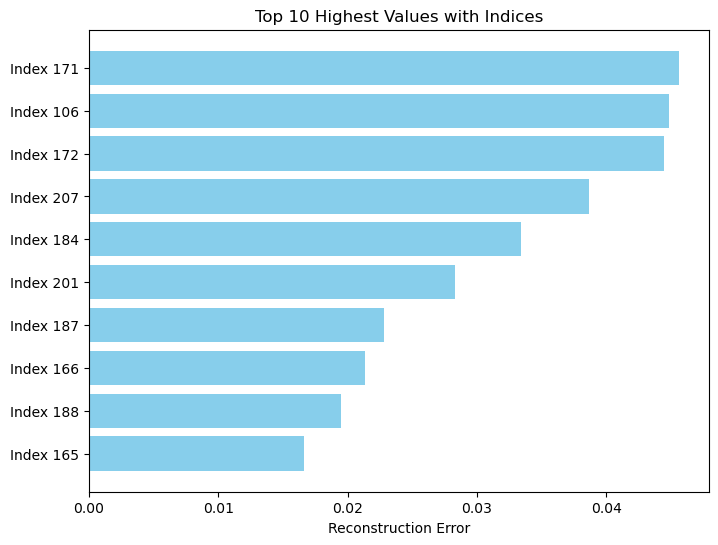

In [136]:
# Ranking the outlier score
top_indices = np.argsort(reconstruction_error)[-10:][::-1]  # sort descending
top_values = reconstruction_error[top_indices]

# plot
plt.figure(figsize=(8, 6))
plt.barh(range(10), top_values, color='skyblue')
plt.yticks(range(10), [f"Index {i}" for i in top_indices])
plt.xlabel("Reconstruction Error")
plt.title("Top 10 Highest Values with Indices")
plt.gca().invert_yaxis()  # largest on top
plt.show()

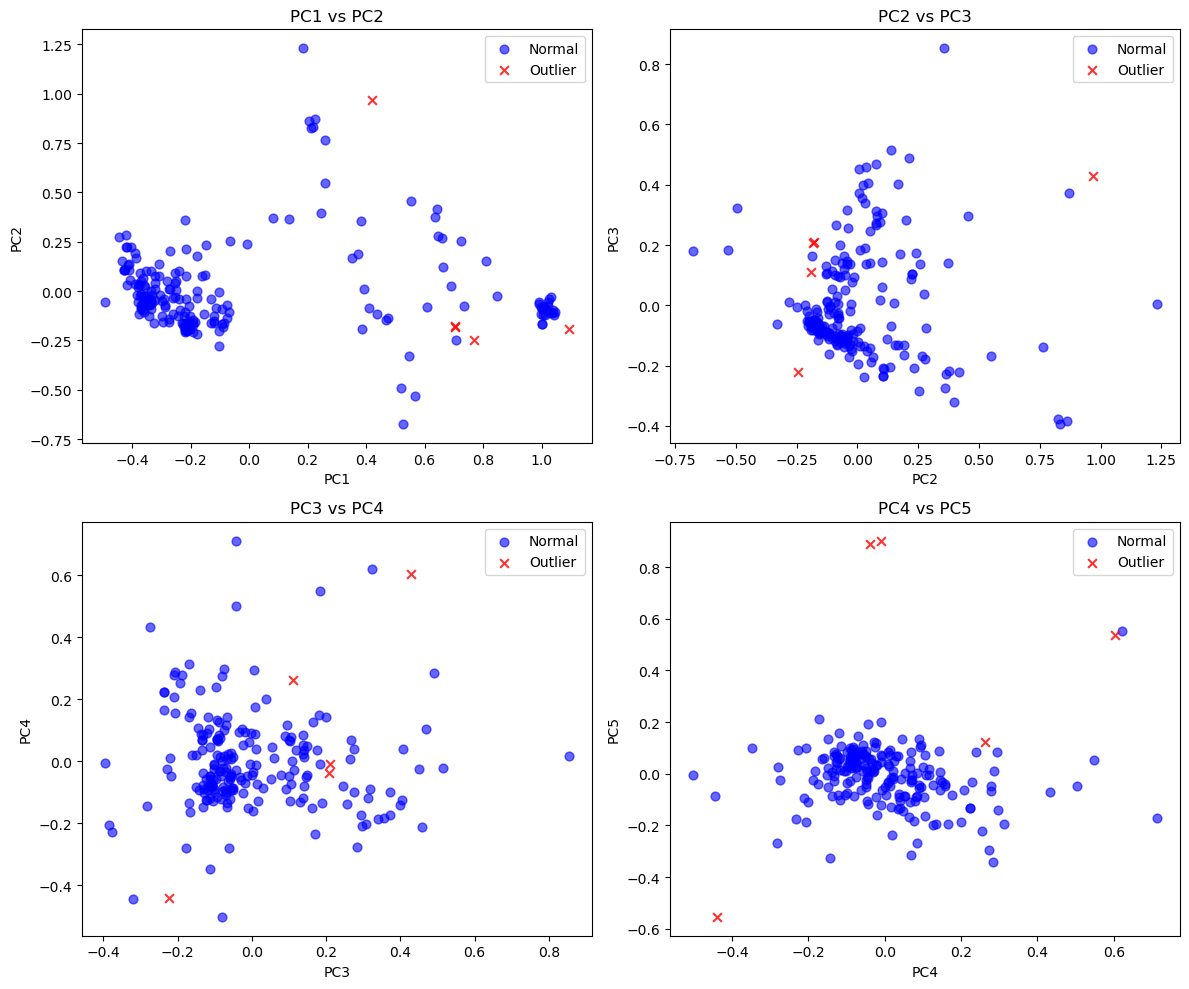

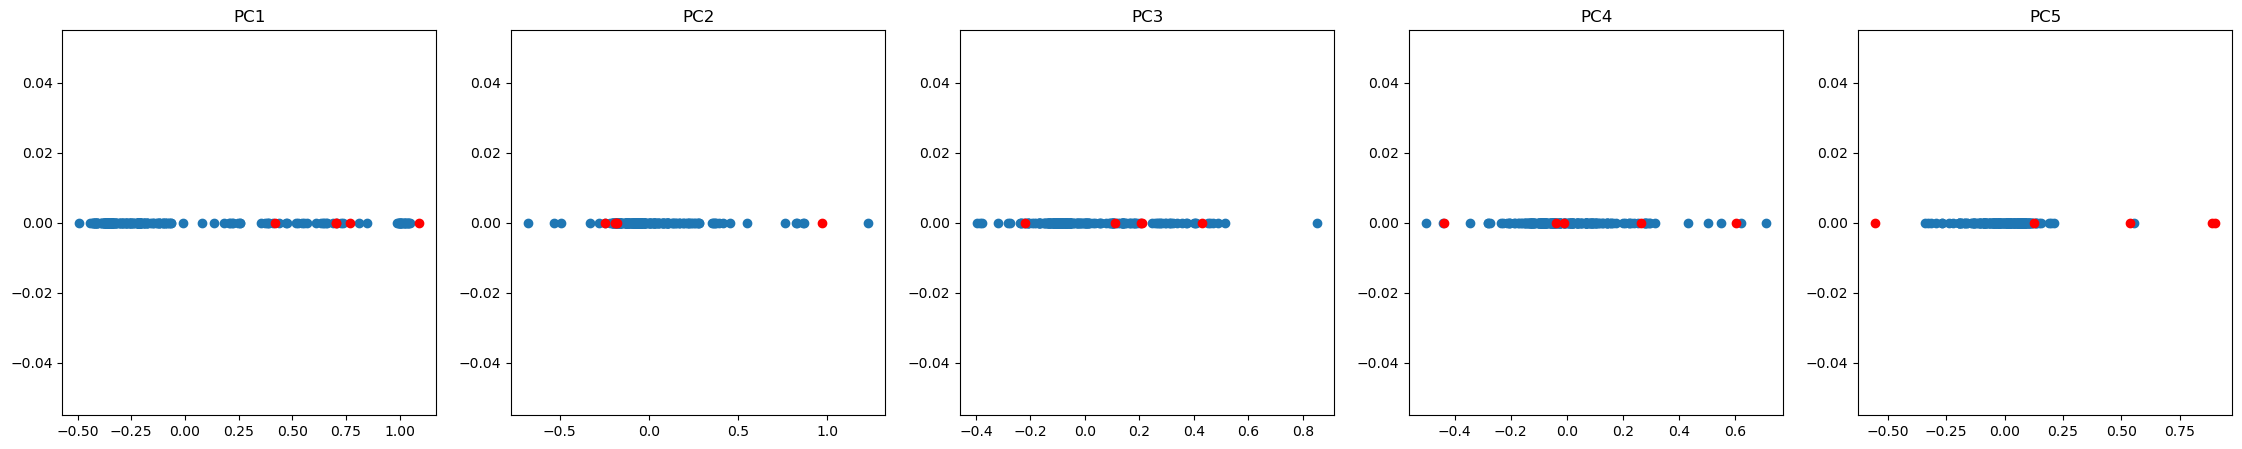

In [137]:
# Visualization of the outlier location in PC scatter plot
pairs = [(0,1), (1,2), (2,3), (3,4)]  # PC1&2, PC2&3, PC3&4, PC4&5
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (i, j) in zip(axes.flatten(), pairs):
    ax.scatter(X_pca[reconstruction_error <= threshold, i], X_pca[reconstruction_error <= threshold, j], 
               c="blue", label="Normal", alpha=0.6, s=40)
    ax.scatter(X_pca[reconstruction_error > threshold, i], X_pca[reconstruction_error > threshold, j], 
               c="red", label="Outlier", alpha=0.8, s=40, marker="x")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.set_title(f"PC{i+1} vs PC{j+1}")
    ax.legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (28,5))
for n in range(5):
        axes[n].scatter(X_pca[reconstruction_error <= threshold, n], 
                        np.zeros(len(X_pca[reconstruction_error <= threshold, n])))
        axes[n].scatter(X_pca[reconstruction_error > threshold, n], 
                        np.zeros(len(X_pca[reconstruction_error > threshold, n])), color = "r")
        axes[n].set_title(f"PC{n+1}")
plt.show()

## Score Distance

Score (Mahalanobis) Distance:
$$
    \textrm{SD}(x)=\sum_{i=1}^{p}\frac{z_i^2}{\lambda_i}
$$
for first $p$ components with the lowest variance.
<div>
<img src="mahalanobis.png" width="200"/>
</div>

PyOD's Weighted Score Distance:
$$
    \textrm{SD}(x)=\sum_{i=1}^{p}\frac{\|x_i-v_i\|_2}{w_i}
$$
with $w_i=\lambda_i$
<div>
<img src="pyod.png" width="200"/>
</div>

(Reference: Zhao, Y., Nasrullah, Z. and Li, Z., 2019. PyOD: A Python Toolbox for Scalable Outlier Detection. Journal of machine learning research (JMLR), 20(96), pp.1-7.)

In [138]:
# Importing PyOD's package for PCA_OD
from pyod.models.pca import PCA as PCA_OD

In [139]:
# Fits a PCA_OD detector to the data
clf = PCA_OD(n_components=5, n_selected_components=5, contamination=0.02) 
clf.fit(X)

# Predicts outlier on the full data
pred = clf.predict(X) 
pred_indices = np.where(pred > 0)
pred_indices

(array([106, 107, 171, 172, 184]),)

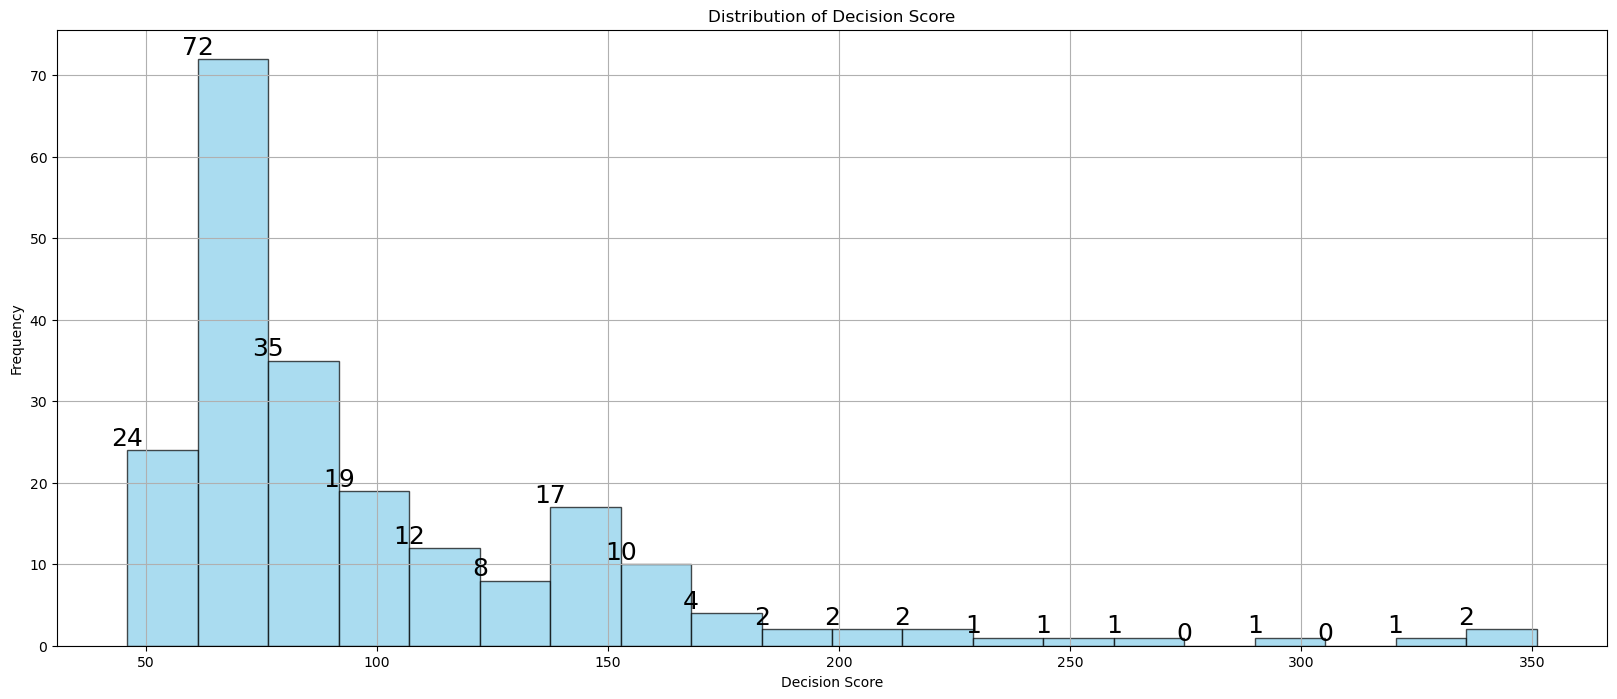

In [140]:
# Plotting distribution of the score
plt.figure(figsize=(20, 8))
counts, bins, _ = plt.hist(clf.decision_scores_, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.title('Distribution of Decision Score')
plt.grid(True)
# Annotate each bin with the count
for i in range(len(counts)):
    plt.text(bins[i], counts[i], str(int(counts[i])), ha='center', va='bottom', fontsize = 18)
plt.show()

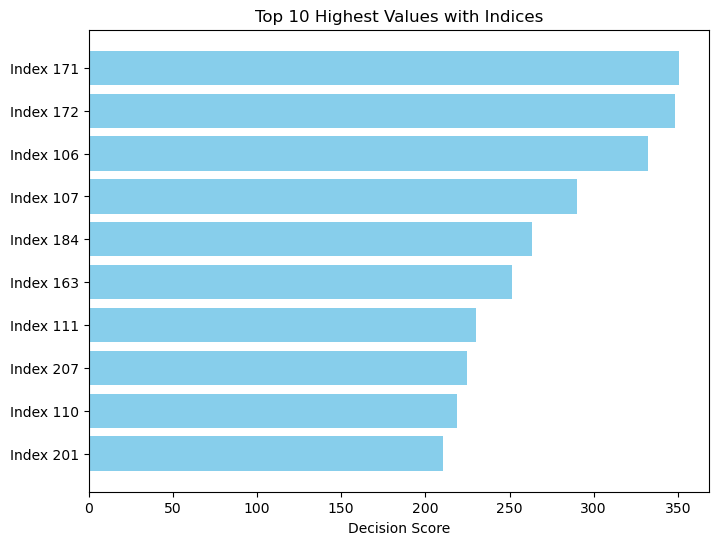

In [141]:
# Ranking the outlier score
top_indices = np.argsort(clf.decision_scores_)[-10:][::-1]  # sort descending
top_values = clf.decision_scores_[top_indices]

# plot
plt.figure(figsize=(8, 6))
plt.barh(range(10), top_values, color='skyblue')
plt.yticks(range(10), [f"Index {i}" for i in top_indices])
plt.xlabel("Decision Score")
plt.title("Top 10 Highest Values with Indices")
plt.gca().invert_yaxis()  # largest on top
plt.show()